In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch import nn, distributions as pyd
import torch.nn.functional as F
import gym
import os
from collections import deque
import random
import math
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from gym.spaces import Box, Discrete, Dict
from RWGE import WheatGrowthEnv  # Import your custom environment
from stable_baselines3 import *
from stable_baselines3.common.env_util import make_vec_env
import gymnasium
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Function to create and return an instance of your custom environment
def create_env_fn():
    return WheatGrowthEnv(start_day=1, start_month=4, end_day=1, end_month=4, render_mode='human')

# Initialize custom environment with make_vec_env
env = make_vec_env(create_env_fn, n_envs=1)

# Access the observation space and action space
observation_space = env.observation_space
action_space = env.action_space

# Now you can use your_observation_space and your_action_space as needed
print("Observation Space:", observation_space)
print("Action Space:", action_space)

Observation Space: Dict('PS': Box(0.0, 11.0, (1,), float32), 'accumulated_excess': Box(0.0, 1000.0, (1,), float32), 'accumulated_gdd': Box(0.0, 3000.0, (1,), float32), 'accumulated_scarcity': Box(0.0, 1000.0, (1,), float32), 'current_day': Discrete(365), 'current_month': Discrete(12), 'current_month_day': Discrete(31), 'current_year': Discrete(3000), 'daily_temperature': Box(0.0, 50.0, (1,), float32), 'etc': Box(0.0, 2.0, (1,), float32), 'growth_stage': Box(0.0, 13.0, (1,), float32), 'harvest': Box(0.0, 100.0, (1,), float32), 'humidity': Box(0.0, 100.0, (1,), float32), 'is_cloudy': Discrete(2), 'is_crop_sick': Discrete(2), 'is_raining': Discrete(2), 'qv2m': Box(0.0, 11.0, (1,), float32), 'rainfall': Box(0.0, 11.0, (1,), float32), 'rn_daily': Box(0.0, 1.0, (1,), float32), 'sky_clearness': Box(0.0, 1.0, (1,), float32), 'soil_moisture_content': Box(0.0, 100.0, (1,), float32), 'water_needs': Box(0.0, 11.0, (1,), float32), 'wind_speed': Box(0.0, 11.0, (1,), float32))
Action Space: Box(0.0, 

C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [3]:
# Hyperparameters
learning_rate = 3e-4#1e-4
critic_learning_rate = 3e-4#5e-5  # Reduced learning rate for critics
tau = 0.005  # for soft update of target parameters
gamma = 0.984  # discount factor for future rewards
max_grad_norm = 1.0  # Reduced max norm for gradient clipping
weight_decay = 1e-5  # L2 regularization strength
alpha = 0.01  # Entropy coefficient
alpha_lr = 3e-4

class Attention(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super(Attention, self).__init__()
        self.fc1 = nn.Linear(input_dim, attention_dim)
        self.fc2 = nn.Linear(attention_dim, input_dim)

    def forward(self, x):
        scores = F.relu(self.fc1(x))
        scores = self.fc2(scores)
        weights = F.softmax(scores, dim=1)
        #print("Weights", weights)
        output = (x * weights).sum(dim=1)
        return output, weights

    
# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 64)#(obs_dim, 256)
        self.fc2 = nn.Linear(64, 64)#(256, 128)
        self.attention = Attention(64, 64)#(128, 128)
        self.mean = nn.Linear(64, action_dim)#(128, action_dim)
        self.log_std = nn.Linear(64, action_dim)#(128, action_dim)
        self.action_bound = action_bound
    
         # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if torch.isnan(x).any():
            raise RuntimeError("NaN detected after fc1")
        
        x = F.relu(self.fc2(x))
        if torch.isnan(x).any():
            raise RuntimeError("NaN detected after fc2")
        
        #print("X = ", x)
        attn_output, _ = self.attention(x.unsqueeze(1))  # Apply attention mechanism
        #print("Attention = ", attn_output)
        mean = self.mean(attn_output)
        log_std = self.log_std(attn_output)
        #print("Mean:", mean)  # Debugging output
        #print("Log std before clamp:", log_std)
        log_std = torch.clamp(log_std, min=-4, max=8)  # Clamp for numerical stability
        #print("Log std after clamp:", log_std)
        std = torch.exp(log_std)
        #print("Std:", std)
        if torch.isnan(std).any():
            raise RuntimeError("NaN detected in std calculation, log_std: " + str(log_std))
    
        # print("Std:", std)
        normal = pyd.Normal(mean, std)
        
        z = normal.rsample()  # Reparameterization trick
        #print("Sampled z:", z)
        z_clamped = torch.clamp(z, min=-3, max=3)
        
        # Scale the output of tanh to the range [0, 11]
        action = (torch.tanh(z_clamped) + 1) * 5.5  # Scale and shift tanh output to [0, 11]


        # action = torch.tanh(z_clamped) * self.action_bound
        #print("Action:", action)
        if (action < 0).any() or (action > 11).any():
            print("Warning: action values out of expected range [0, 11]")
            action = torch.clamp(action, min=0, max=11)

        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) / 121 + 1e-6)
        #print("Log Prob:", log_prob)
        
        if torch.isnan(log_prob).any():
            print("NaN in log_prob detected")
            print("z:", z)
            print("action:", action)
            print("1 - action.pow(2) /121:", 1 - action.pow(2)/121)

        if log_prob.dim() > 1:
            log_prob = log_prob.sum(-1, keepdim=True)  # Sum across the action dimension if needed
        return action, log_prob

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim + action_dim, 64)#(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(64, 64)#(256, 128)
        self.attention = Attention(64, 64)#(128, 128)
        self.fc3 = nn.Linear(64, 1)#(128, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        attn_output, _ = self.attention(x.unsqueeze(1))  # Apply attention mechanism
        value = self.fc3(attn_output)
        return value

# Function to calculate dimension of observation space
def calc_input_shape(space):
    if isinstance(space, (gym.spaces.Dict, gymnasium.spaces.Dict)):
        total_dim = sum(calc_input_shape(subspace) for _, subspace in space.spaces.items())
        print("Total dimension for Dict:", total_dim)  # Diagnostic print
        return total_dim
    elif isinstance(space, (gym.spaces.Box, gymnasium.spaces.Box)):
        box_dim = int(np.prod(space.shape))
        print("Dimension for Box:", box_dim)  # Diagnostic print
        return box_dim
    elif isinstance(space, (gym.spaces.Discrete, gymnasium.spaces.Discrete)):
        print("Dimension for Discrete: 1")  # Diagnostic print
        return 1
    else:
        raise TypeError(f"Unsupported space type: {type(space)}")

# Get dimensions
# Test and debug the calculation of observation dimensions
try:
    obs_dim = calc_input_shape(observation_space)
except Exception as e:
    print("Error calculating observation dimensions:", str(e))

action_dim = action_space.shape[0]
action_bound = action_space.high[0]

print("Observation Dimension:", obs_dim)  # Diagnostic print
print("Action Dimension:", action_dim)  # Diagnostic print
print("Action Bound:", action_bound)  # Diagnostic print

# Define init_weights function outside the class
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)
        
# Initialize networks
actor = Actor(obs_dim, action_dim, action_bound).to(device)
critic1 = Critic(obs_dim, action_dim).to(device)
critic2 = Critic(obs_dim, action_dim).to(device)
critic1_target = Critic(obs_dim, action_dim).to(device)
critic2_target = Critic(obs_dim, action_dim).to(device)

actor.apply(init_weights)
critic1.apply(init_weights)
critic2.apply(init_weights)
critic1_target.apply(init_weights)
critic2_target.apply(init_weights)

# Copy weights to the target networks
critic1_target.load_state_dict(critic1.state_dict())
critic2_target.load_state_dict(critic2.state_dict())

# Optimizers with L2 regularization
actor_optimizer = Adam(actor.parameters(), lr=learning_rate, weight_decay=weight_decay)
critic1_optimizer = Adam(critic1.parameters(), lr=critic_learning_rate, weight_decay=weight_decay)
critic2_optimizer = Adam(critic2.parameters(), lr=critic_learning_rate, weight_decay=weight_decay)
#alpha = torch.tensor(alpha, requires_grad=True)
#alpha_optimizer = torch.optim.Adam([alpha], lr=alpha_lr)

Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Discrete: 1
Dimension for Discrete: 1
Dimension for Discrete: 1
Dimension for Discrete: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Discrete: 1
Dimension for Discrete: 1
Dimension for Discrete: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Dimension for Box: 1
Total dimension for Dict: 23
Observation Dimension: 23
Action Dimension: 1
Action Bound: 11.0


In [4]:
import torch
from torch.nn.functional import mse_loss
import random
from collections import deque
import matplotlib.pyplot as plt

# Hyperparameters for training
initial_action_noise_stddev = 0.1 # Standard deviation of action noise
final_action_noise_stddev = 0.01
noise_decay_rate = 0.999

batch_size = 64
buffer_size = 80000#100000#50000
min_samples_before_train = 500
update_every = 5
updates_per_step = 1
target_update_freq = 50  # Update target networks every 10 updates
# Initialize target entropy
target_entropy = -action_dim
# Initialize entropy coefficient alpha
log_alpha = torch.tensor(np.log(0.2), requires_grad=True, device=device)
alpha_optimizer = optim.Adam([log_alpha], lr=3e-4)

# Initialize global variables
update_counter = 0
# Lists to store data for plotting
episode_rewards = []
mean_reward = []
critic_losses = []
actor_losses = []
actions = []


# Function to update action noise
def get_action_noise_stddev(episode):
    return max(final_action_noise_stddev, initial_action_noise_stddev * (noise_decay_rate ** episode))

# Plotting Moving Averages
def plot_moving_average(data, window_size=100):
    moving_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return moving_avg

def flatten_state(state_dict):
    state_array = []
    for key, value in state_dict.items():
        if isinstance(value, np.ndarray):
            value[np.isnan(value)] = 0.0  # Replace NaNs with 0
            state_array.extend(value.flatten())
        elif isinstance(value, int) or isinstance(value, float):
            if np.isnan(value):
                value = 0.0  # Replace NaNs with 0
            state_array.append(value)
        else:
            raise ValueError(f"Unsupported state type for key {key}: {type(value)}")
    return np.array(state_array)


def normalize_state(state):
    for key, value in state.items():
        if isinstance(value, np.ndarray):
            state[key] = (value - value.mean()) / (value.std() + 1e-8)
        elif isinstance(value, (int, float)):
            if key == 'current_day':
                state[key] = (value - 182.5) / 105.0
            elif key == 'current_month':
                state[key] = (value - 6.5) / 3.5
            elif key == 'current_month_day':
                state[key] = (value - 15.5) / 9.0
            elif key == 'current_year':
                state[key] = (value - 1500) / 750
            else:
                state[key] = (value - 0.5)  # Example normalization for binary states
    return state

def clip_reward(reward, min_reward, max_reward):
    return max(min(reward, max_reward), min_reward)


# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

# Instantiate the replay buffer
replay_buffer = ReplayBuffer(buffer_size)


# Function to update the model
def update_model():
    global update_counter  # Declare update_counter as global to modify it within the function
    if len(replay_buffer) < min_samples_before_train:
        return
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    states = torch.FloatTensor(states).to(device)
    actions = torch.FloatTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Predict actions and log probabilities with the current policy
    new_actions, log_probs = actor(states)
    next_actions, next_log_probs = actor(next_states)
    
    for name, param in actor.named_parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any():
                print(f"NaN gradient in {name}")
    
    # Calculate the target Q values
    next_q1 = critic1_target(next_states, next_actions.detach())
    next_q2 = critic2_target(next_states, next_actions.detach())
    next_v = torch.min(next_q1, next_q2) - alpha * next_log_probs.detach()
    expected_q = rewards + (1 - dones) * gamma * next_v

    # Calculate the losses for both critics
    current_q1 = critic1(states, actions)
    current_q2 = critic2(states, actions)
    critic1_loss = F.mse_loss(current_q1, expected_q)
    critic2_loss = F.mse_loss(current_q2, expected_q)
    combined_loss = critic1_loss + critic2_loss

    # Zero gradients, perform a backward pass, and update the weights.
    critic1_optimizer.zero_grad()
    critic2_optimizer.zero_grad()
    combined_loss.backward()
    # Clip gradients to prevent explosion
    nn.utils.clip_grad_norm_(critic1.parameters(), max_norm=max_grad_norm)
    nn.utils.clip_grad_norm_(critic2.parameters(), max_norm=max_grad_norm)
    
    critic1_optimizer.step()
    critic2_optimizer.step()

     # Delayed policy updates
    actor_loss = -(torch.min(critic1(states, new_actions), critic2(states, new_actions)) - alpha * log_probs).mean()
    
    actor_optimizer.zero_grad()
    actor_loss.backward()
    nn.utils.clip_grad_norm_(actor.parameters(), max_norm=max_grad_norm)
    actor_optimizer.step()
    
    # Update alpha
    alpha_loss = -(log_alpha * (log_probs + target_entropy).detach()).mean()
    alpha_optimizer.zero_grad()
    alpha_loss.backward()
    alpha_optimizer.step()

    # Less frequent target network updates
    if update_counter % target_update_freq == 0:
         # Soft update target networks
        for param, target_param in zip(critic1.parameters(), critic1_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(critic2.parameters(), critic2_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    update_counter += 1
    
    return combined_loss, actor_loss


def normalize_reward(reward, reward_mean, reward_std):
#     print("\nREWARD --- :", reward)
#     print("\nMEAN REWARD --- :", reward_mean)
#     print("\nREWARD STD --- :", reward_std, "\n")
    return (reward - reward_mean) / (reward_std + 1e-8)

reward_buffer = []
reward_mean = 0
reward_std = 1

# Update the reward normalization statistics
def update_reward_stats(reward):
    global reward_mean, reward_std
    reward_buffer.append(reward)
    if len(reward_buffer) > 1000:
        reward_buffer.pop(0)
    reward_mean = np.mean(reward_buffer)
    reward_std = np.std(reward_buffer)


def check_nan_in_state(state):
    """Recursively check for NaN values in the state dictionary."""
    if isinstance(state, dict):
        for key, value in state.items():
            if check_nan_in_state(value):
                return True
    elif isinstance(state, np.ndarray):
        if np.isnan(state).any():
            return True
    elif isinstance(state, (float, int)):  # Directly check if it's a scalar
        if np.isnan(state):
            return True
    return False


# Training loop
num_episodes = 2008
# Training loop
for episode in range(num_episodes):
    state = env.reset()
    if check_nan_in_state(state):
        print("Skipping episode due to NaN in initial state")
        continue
        
    state = normalize_state(state)  # Normalize the state
    state = flatten_state(state)  # Ensure the state is correctly flattened
    episode_reward = 0
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).to(device)
        # Before passing data to the network
        if torch.isnan(state_tensor).any() or torch.isinf(state_tensor).any():
            raise ValueError("State tensor contains NaN or Inf.")
        
        action, log_prob = actor(state_tensor.unsqueeze(0))  # Ensure it's treated as a batch of one
        action = action.squeeze(0).detach().cpu().numpy()  # Remove batch dimension before stepping the environment
        action_noise_stddev = get_action_noise_stddev(episode)
        # Add noise to action for exploration
        action = np.clip(action + np.random.normal(0, action_noise_stddev, size=action.shape), 0, action_bound)
        actions.append(action)
        
        # Compute entropy
        entropy = -log_prob.mean()
        
        #print(f'-------------In episode {episode}\n')
#         print(f'Selected Action: {action}\n ')
        next_state, reward, done, _ = env.step(action)
        
        episode_reward += reward
        reward = normalize_reward(reward, reward_mean, reward_std)  # Normalize reward
        update_reward_stats(reward)  # Update reward statistics
        
#         print(f'Reward: {reward} - Growth Stage: {next_state["growth_stage"]} - Harvest: {next_state["harvest"]} - Water Needs {next_state["water_needs"]} -Excess: {next_state["accumulated_excess"]} -  Scarcity: {next_state["accumulated_scarcity"]} - ')
#         print(f'\nIs Done: {done}')
        
        next_state = normalize_state(next_state)  # Normalize the next state
        next_state = flatten_state(next_state)
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        
        if len(replay_buffer) > min_samples_before_train:
            critic_loss, actor_loss = update_model()
#             if episode % 80 == 1:
#                 critic_losses.append(critic_loss)
#                 actor_losses.append(actor_loss)    

    if episode % 4 == 0:
        episode_rewards.append(episode_reward)
        if len(episode_rewards[-101:-1]) == 0:
            ep_mean_rew = -np.inf
        else: 
            ep_mean_rew = round(float(np.mean(episode_rewards[-101:-1])), 2)
        mean_reward.append(ep_mean_rew)
        if len(replay_buffer) > min_samples_before_train:
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
        print("-----------------------------------------------")
        print(f"Episode: {episode}, Reward: {episode_reward}, Mean Reward: {ep_mean_rew}")

-----------------------------------------------
Episode: 0, Reward: [-19.322195], Mean Reward: -inf
-----------------------------------------------
Episode: 4, Reward: [-18.637674], Mean Reward: -19.32
-----------------------------------------------
Episode: 8, Reward: [-15.148964], Mean Reward: -18.98
-----------------------------------------------
Episode: 12, Reward: [-19.61997], Mean Reward: -17.7
-----------------------------------------------
Episode: 16, Reward: [-14.923606], Mean Reward: -18.18
-----------------------------------------------
Episode: 20, Reward: [-15.676189], Mean Reward: -17.53
-----------------------------------------------
Episode: 24, Reward: [-19.345514], Mean Reward: -17.22
-----------------------------------------------
Episode: 28, Reward: [-18.200514], Mean Reward: -17.52
-----------------------------------------------
Episode: 32, Reward: [-16.855217], Mean Reward: -17.61
-----------------------------------------------
Episode: 36, Reward: [-14.937757

-----------------------------------------------
Episode: 320, Reward: [-8.37014], Mean Reward: -14.98
-----------------------------------------------
Episode: 324, Reward: [-8.722948], Mean Reward: -14.9
-----------------------------------------------
Episode: 328, Reward: [-10.86792], Mean Reward: -14.82
-----------------------------------------------
Episode: 332, Reward: [-10.782279], Mean Reward: -14.78
-----------------------------------------------
Episode: 336, Reward: [-9.817283], Mean Reward: -14.73
-----------------------------------------------
Episode: 340, Reward: [-8.342494], Mean Reward: -14.67
-----------------------------------------------
Episode: 344, Reward: [-10.768759], Mean Reward: -14.6
-----------------------------------------------
Episode: 348, Reward: [-10.754395], Mean Reward: -14.55
-----------------------------------------------
Episode: 352, Reward: [-11.05896], Mean Reward: -14.51
-----------------------------------------------
Episode: 356, Reward: [-7

-----------------------------------------------
Episode: 640, Reward: [-8.250853], Mean Reward: -9.13
-----------------------------------------------
Episode: 644, Reward: [-7.1822042], Mean Reward: -9.06
-----------------------------------------------
Episode: 648, Reward: [-3.9885077], Mean Reward: -8.98
-----------------------------------------------
Episode: 652, Reward: [-6.515873], Mean Reward: -8.92
-----------------------------------------------
Episode: 656, Reward: [-1.4630394], Mean Reward: -8.8
-----------------------------------------------
Episode: 660, Reward: [-1.942803], Mean Reward: -8.72
-----------------------------------------------
Episode: 664, Reward: [-3.9600801], Mean Reward: -8.65
-----------------------------------------------
Episode: 668, Reward: [-2.292663], Mean Reward: -8.53
-----------------------------------------------
Episode: 672, Reward: [-3.8032768], Mean Reward: -8.37
-----------------------------------------------
Episode: 676, Reward: [-9.0178

-----------------------------------------------
Episode: 960, Reward: [-3.4518342], Mean Reward: -4.26
-----------------------------------------------
Episode: 964, Reward: [-0.4843229], Mean Reward: -4.23
-----------------------------------------------
Episode: 968, Reward: [-0.90868527], Mean Reward: -4.18
-----------------------------------------------
Episode: 972, Reward: [-4.2054763], Mean Reward: -4.11
-----------------------------------------------
Episode: 976, Reward: [-7.935908], Mean Reward: -4.08
-----------------------------------------------
Episode: 980, Reward: [-2.2450538], Mean Reward: -4.09
-----------------------------------------------
Episode: 984, Reward: [0.43810785], Mean Reward: -4.05
-----------------------------------------------
Episode: 988, Reward: [-4.48318], Mean Reward: -3.98
-----------------------------------------------
Episode: 992, Reward: [-0.6502313], Mean Reward: -3.96
-----------------------------------------------
Episode: 996, Reward: [-3.7

-----------------------------------------------
Episode: 1280, Reward: [-4.341853], Mean Reward: -3.01
-----------------------------------------------
Episode: 1284, Reward: [-1.8930571], Mean Reward: -3.04
-----------------------------------------------
Episode: 1288, Reward: [-6.151179], Mean Reward: -3.0
-----------------------------------------------
Episode: 1292, Reward: [-2.1287663], Mean Reward: -3.03
-----------------------------------------------
Episode: 1296, Reward: [-2.0448546], Mean Reward: -3.02
-----------------------------------------------
Episode: 1300, Reward: [-2.9436226], Mean Reward: -2.99
-----------------------------------------------
Episode: 1304, Reward: [-2.690496], Mean Reward: -2.97
-----------------------------------------------
Episode: 1308, Reward: [-4.635403], Mean Reward: -2.94
-----------------------------------------------
Episode: 1312, Reward: [-5.158263], Mean Reward: -2.99
-----------------------------------------------
Episode: 1316, Reward:

-----------------------------------------------
Episode: 1600, Reward: [-5.0502605], Mean Reward: -2.4
-----------------------------------------------
Episode: 1604, Reward: [-4.55428], Mean Reward: -2.39
-----------------------------------------------
Episode: 1608, Reward: [-2.738154], Mean Reward: -2.34
-----------------------------------------------
Episode: 1612, Reward: [-6.137778], Mean Reward: -2.35
-----------------------------------------------
Episode: 1616, Reward: [2.7372866], Mean Reward: -2.33
-----------------------------------------------
Episode: 1620, Reward: [-4.0212584], Mean Reward: -2.27
-----------------------------------------------
Episode: 1624, Reward: [-5.9345775], Mean Reward: -2.31
-----------------------------------------------
Episode: 1628, Reward: [-3.51288], Mean Reward: -2.34
-----------------------------------------------
Episode: 1632, Reward: [-6.5048738], Mean Reward: -2.39
-----------------------------------------------
Episode: 1636, Reward: [

-----------------------------------------------
Episode: 1920, Reward: [-3.5869744], Mean Reward: -1.87
-----------------------------------------------
Episode: 1924, Reward: [-3.6768198], Mean Reward: -1.9
-----------------------------------------------
Episode: 1928, Reward: [-1.101526], Mean Reward: -1.87
-----------------------------------------------
Episode: 1932, Reward: [-4.3648915], Mean Reward: -1.88
-----------------------------------------------
Episode: 1936, Reward: [-1.2929947], Mean Reward: -1.96
-----------------------------------------------
Episode: 1940, Reward: [-5.821295], Mean Reward: -2.0
-----------------------------------------------
Episode: 1944, Reward: [-2.9300983], Mean Reward: -1.98
-----------------------------------------------
Episode: 1948, Reward: [0.30208182], Mean Reward: -1.96
-----------------------------------------------
Episode: 1952, Reward: [-2.0266428], Mean Reward: -1.9
-----------------------------------------------
Episode: 1956, Reward

In [5]:
mean_rewards = np.mean(episode_rewards)
print(mean_rewards)

-5.562509


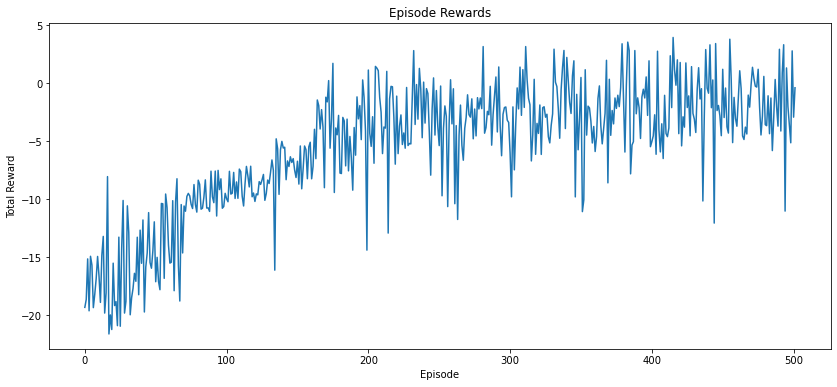

In [6]:
# After training, plot the collected data
plt.figure(figsize=(14, 6))

# Plot episode rewards
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')


plt.show()

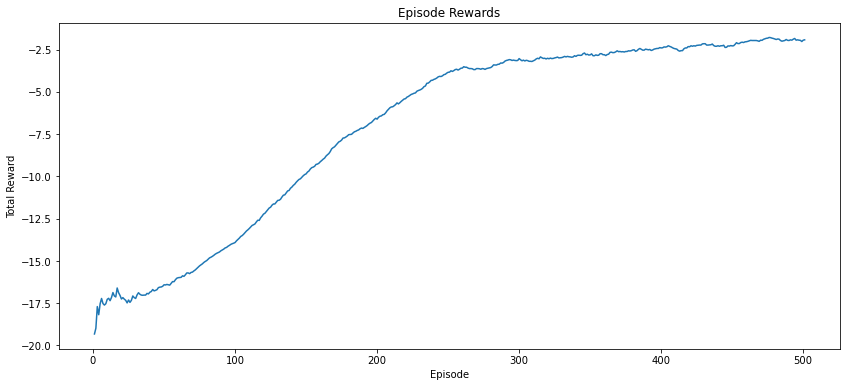

In [7]:
# After training, plot the collected data
plt.figure(figsize=(14, 6))

# Plot episode rewards
plt.plot(mean_reward)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.show()

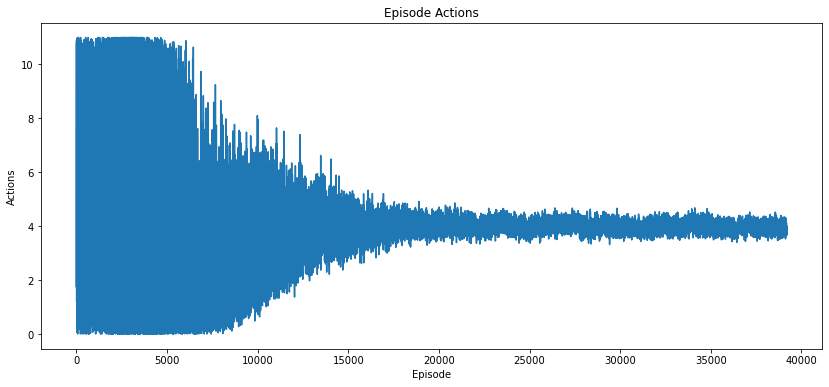

In [8]:
# After training, plot the collected data
plt.figure(figsize=(14, 6))

# Plot episode rewards
#plt.subplot(1, 2, 1)
plt.plot(actions)
plt.title('Episode Actions')
plt.xlabel('Episode')
plt.ylabel('Actions')

plt.show()

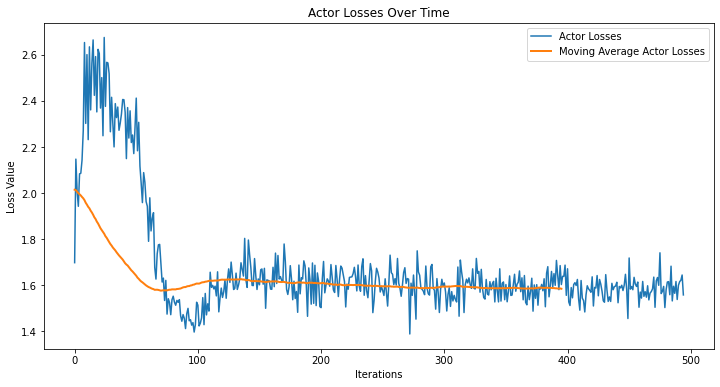

In [9]:
# Extracting values for plotting
actor_losses_values = [tensor.item() for tensor in actor_losses]

plt.figure(figsize=(12, 6))
plt.plot(actor_losses_values, label='Actor Losses')
plt.plot(plot_moving_average(actor_losses_values), label='Moving Average Actor Losses', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.title('Actor Losses Over Time')
plt.legend()
plt.show()

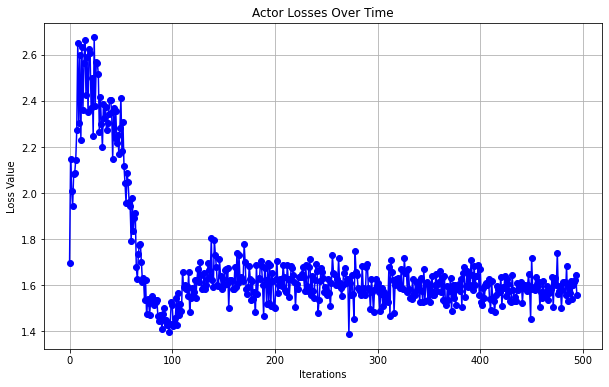

In [10]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actor_losses_values, marker='o', linestyle='-', color='b')
plt.title('Actor Losses Over Time')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

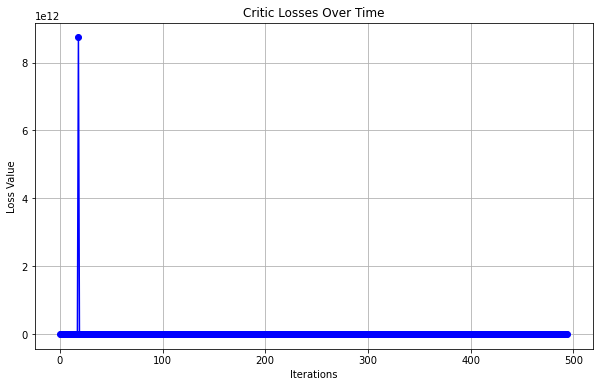

In [11]:

critic_losses_values = [tensor.item() for tensor in critic_losses]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(critic_losses_values, marker='o', linestyle='-', color='b')
plt.title('Critic Losses Over Time')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

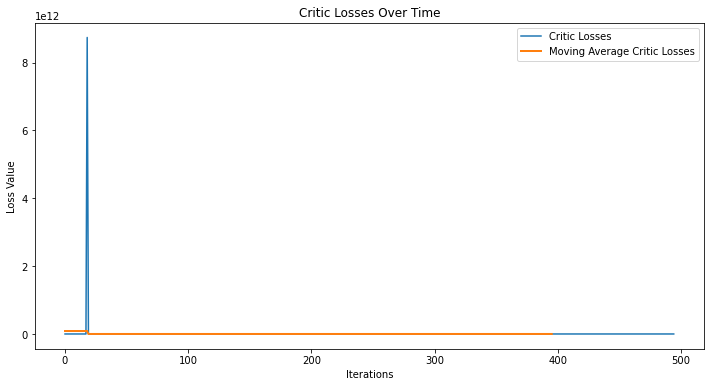

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(critic_losses_values, label='Critic Losses')
plt.plot(plot_moving_average(critic_losses_values), label='Moving Average Critic Losses', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.title('Critic Losses Over Time')
plt.legend()
plt.show()

In [13]:
total_rewards = []
# Test the trained model and calculate mean reward
def test_model(env, actor, num_episodes=100):
    for episode in range(num_episodes):
        state = env.reset()
        state = normalize_state(state)  # Normalize the state
        state = flatten_state(state)  # Ensure the state is correctly flattened
        episode_reward = 0
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(state).to(device)
            action, _ = actor(state_tensor.unsqueeze(0))  # Ensure it's treated as a batch of one
            action = action.squeeze(0).detach().cpu().numpy()  # Remove batch dimension before stepping the environment
            action = np.clip(action, 0, action_space.high)  # Clip action to the valid range

            next_state, reward, done, _ = env.step(action)
            next_state = normalize_state(next_state)  # Normalize the next state
            next_state = flatten_state(next_state)

            state = next_state
            episode_reward += reward
        
        total_rewards.append(episode_reward)
        print(f"Episode: {episode}, Reward: {episode_reward}")
    
    test_mean_reward = np.mean(total_rewards)
    print(f"Mean Reward over {num_episodes} episodes: {test_mean_reward}")
    return test_mean_reward

# Assuming the actor is already loaded and env is defined
test_mean_reward = test_model(env, actor, num_episodes=10)

Episode: 0, Reward: [-0.47993487]
Episode: 1, Reward: [-2.6413677]
Episode: 2, Reward: [-2.0015283]
Episode: 3, Reward: [-3.7256982]
Episode: 4, Reward: [-0.1364575]
Episode: 5, Reward: [-5.130621]
Episode: 6, Reward: [-2.6452565]
Episode: 7, Reward: [-2.8527498]
Episode: 8, Reward: [-2.1709564]
Episode: 9, Reward: [-3.572596]
Mean Reward over 10 episodes: -2.5357165336608887


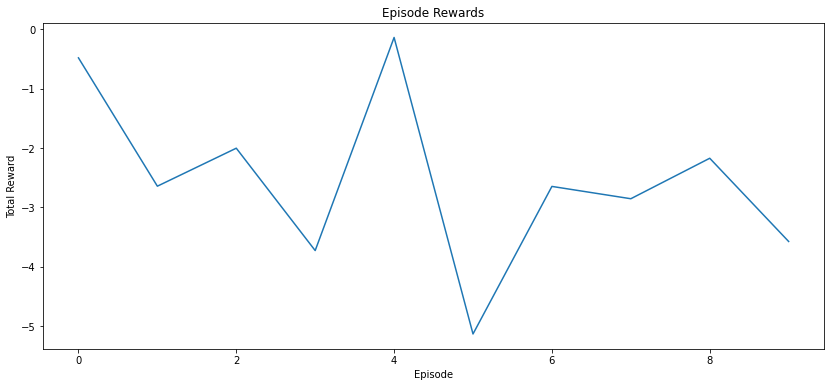

In [14]:
# After training, plot the collected data
plt.figure(figsize=(14, 6))

# Plot episode rewards
plt.plot(total_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')


plt.show()

In [15]:
# Helper function to flatten a list of arrays
def flatten_list(data):
    return [item.flatten()[0] for item in data]

# Helper function to convert tensors to floats
def tensor_to_float(data):
    return [item.item() if isinstance(item, torch.Tensor) else item for item in data]

In [16]:
# Save each list as a separate CSV file
def save_list_to_csv(data, filename):
    # Convert tensors to floats if necessary
    if isinstance(data, (list, np.ndarray)) and isinstance(data[0], (torch.Tensor, np.ndarray, list)):
        data = tensor_to_float(data)
    if isinstance(data, (list, np.ndarray)) and isinstance(data[0], (np.ndarray, list)):
        data = flatten_list(data)
    df = pd.DataFrame({filename: data})
    df.to_csv(f'{filename}.csv', index=False)

In [17]:
#save_list_to_csv(episode_rewards, 'episode_rewards_ada_noise')
save_list_to_csv(mean_reward, 'mean_reward_ada_noise')
save_list_to_csv(critic_losses, 'critic_losses_ada_noise')
save_list_to_csv(actor_losses, 'actor_losses_ada_noise')
#save_list_to_csv(actions, 'actions_ada_noise')

# Example Input

In [18]:
x = torch.tensor([[1.0, 2.0, 3.0]])

In [19]:
attention_v2 = Attention(input_dim=3, attention_dim=2)

# Forward pass
output_v2, weights_v2 = attention_v2(x)
print("AttentionV2 Output:", output_v2)
print("AttentionV2 Weights:", weights_v2)


AttentionV2 Output: tensor([1.8330], grad_fn=<SumBackward1>)
AttentionV2 Weights: tensor([[0.4578, 0.2513, 0.2908]], grad_fn=<SoftmaxBackward0>)


In [20]:
attention_v2.fc1.weight.data = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])
attention_v2.fc1.bias.data = torch.tensor([0.1, 0.2])
attention_v2.fc2.weight.data = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])
attention_v2.fc2.bias.data = torch.tensor([0.1, 0.2, 0.3])

In [21]:
scores1 = F.relu(x @ attention_v2.fc1.weight.T + attention_v2.fc1.bias)
print(scores1)

tensor([[1.5000, 3.4000]], grad_fn=<ReluBackward0>)


In [22]:
scores2 = scores1 @ attention_v2.fc2.weight + attention_v2.fc2.bias
print(scores2)

tensor([[1.6100, 2.2000, 2.7900]], grad_fn=<AddBackward0>)


In [23]:
weights = F.softmax(scores2, dim=1)
print(weights)

tensor([[0.1651, 0.2978, 0.5372]], grad_fn=<SoftmaxBackward0>)


In [24]:
output = (x * weights).sum(dim=1)
print(output)

tensor([2.3721], grad_fn=<SumBackward1>)
